# Analysis of Potential Store Locations

## Introduction

This Jupyter Notebook analyzes potential store locations based on data obtained from loopnet.com and the census website.

### Goals
- Determine the suitability of potential store locations.
- Analyze the correlation between various factors and suitability.

## Data Overview
- **Data Sources:**
  - *Addresses:* Open addresses for rent obtained from loopnet.com.
  - *Existing Apple Stores Addresses:* obtained from apple.com.
  - *Income:* Income data obtained from the census website.

- **Initial Variables:**
  - `Address`: Address of the potential location.
  - `City`: City where the potential location is located.
  - `ZIP`: ZIP code of the potential location.
  - `Year Built`: Year the building was constructed.
  - `SF`: Square footage of the potential location.
  - `Price`: Rental price of the potential location.

- **Derived Variables:**
  - `potential_location`: Binary variable indicating suitability of a location.
  - `nearest_distance`: Distance to the nearest existing store.
  - `weighted_avg_income`: Weighted average income in the area.
  - `yearly_price_per_SF`: Yearly price per square foot.



## Libraries Import

In [373]:
import numpy as np
import pandas as pd
import geopandas as gpd
import re
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from IPython.display import IFrame
import seaborn as sns

## Function to Read Text File Content

In [374]:
def text_file_content(file_path):
    with open(file_path, 'r') as file:
        content = file.read().splitlines()
    return content

# Example usage:
file_path = 'nyc_rentals_ret.txt'  # loopnet addresses text file
lines_text = (text_file_content(file_path))
# Create a DataFrame
labels = ['Address', 'City and ZIP', 'Year Built', 'SF', 'Price']

def extract_info(text_lines):
    var_list = []
    for j in range(1,6):
        var_list.append([text_lines[i] for i in range(j,len(text_lines), 6)]) 
    return var_list

sublists_vals = (extract_info(lines_text))

## Display Initial Dataframe and Variables Info

In [375]:
df = pd.DataFrame(sublists_vals, index=labels).T
df

,Address,City and ZIP,Year Built,SF,Price
0,2586 Linden Blvd,"Brooklyn, NY, 11208",Built in 2015,"8,500 SF Retail Space",$48.00 SF/YR
1,103 Macdougal St,"New York, NY, 10012",Built in 1900,"5,000 - 12,000 SF Retail Spaces",$120.00 SF/YR
2,336 W 23rd St,"New York, NY, 10011",Built in 1910,"2,000 - 6,200 SF Retail Spaces",48.00 - $49.00 SF/YR
3,1 Wall Street,"New York, NY, 10005",Built in 1904,"5,000 - 12,500 SF Retail Spaces",84.00 - $88.00 SF/YR
4,31 W 21st St,"New York, NY, 10010",Built in 1908,"9,000 SF Retail Spaces",$115.00 SF/YR
...,...,...,...,...,...
506,625-649 Eighth Ave,"New York, NY, 10018",Built in 1950,"196 - 29,905 SF Retail Spaces",none
507,4473 Amboy Rd,"Staten Island, NY, 10312",Built in 2022,"2,000 - 15,000 SF Retail Space",none
508,143 Fulton St,"New York, NY, 10038",Built in 2018,"570 - 8,444 SF Retail Spaces",none
509,768 5th Ave,"New York, NY, 10019",Built in 1907,"440 - 32,940 SF Retail Spaces",none


In [376]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Address       511 non-null    object
 1   City and ZIP  511 non-null    object
 2   Year Built    511 non-null    object
 3   SF            511 non-null    object
 4   Price         511 non-null    object
dtypes: object(5)
memory usage: 20.1+ KB


The dataset consists of a DataFrame with 511 entries and 5 columns:

- **Address**: Object type, 511 non-null values.
- **City and ZIP**: Object type, 511 non-null values.
- **Year Built**: Object type, 511 non-null values.
- **SF**: Object type, 511 non-null values.
- **Price**: Object type, 511 non-null values.

It's important to note that these variables need to be converted to int or float for our analysis.


### Splitting 'City and ZIP' Column

We split the 'City and ZIP' column into 'City' and 'ZIP' columns since we need the ZIP code for further analysis.


In [377]:
df[['City', 'ZIP']] = df['City and ZIP'].str.split('NY, ', expand=True)


In [378]:
df.head(20)

,Address,City and ZIP,Year Built,SF,Price,City,ZIP
0,2586 Linden Blvd,"Brooklyn, NY, 11208",Built in 2015,"8,500 SF Retail Space",$48.00 SF/YR,"Brooklyn,",11208
1,103 Macdougal St,"New York, NY, 10012",Built in 1900,"5,000 - 12,000 SF Retail Spaces",$120.00 SF/YR,"New York,",10012
2,336 W 23rd St,"New York, NY, 10011",Built in 1910,"2,000 - 6,200 SF Retail Spaces",48.00 - $49.00 SF/YR,"New York,",10011
3,1 Wall Street,"New York, NY, 10005",Built in 1904,"5,000 - 12,500 SF Retail Spaces",84.00 - $88.00 SF/YR,"New York,",10005
4,31 W 21st St,"New York, NY, 10010",Built in 1908,"9,000 SF Retail Spaces",$115.00 SF/YR,"New York,",10010
5,59 N 6th St,"Brooklyn, NY, 11249",Built in 2020,"4,200 SF Retail Space",$250.00 SF/YR,"Brooklyn,",11249
6,135 W 36th St,"New York, NY, 10018",Built in 1925,"2,439 - 27,499 SF Spaces",$76.50 SF/YR,"New York,",10018
7,946 McDonald Ave,"Brooklyn, NY, 11218",Built in 1933,"1,000 - 4,500 SF Retail Spaces",$29.00 SF/YR,"Brooklyn,",11218
8,2705-2715 Mermaid Ave,"Brooklyn, NY, 11224",Built in 1930,"5,000 SF Retail Space",$19.68 SF/YR,"Brooklyn,",11224
9,218 Newel St,"Brooklyn, NY, 11222",Built in 1931,"2,830 - 11,760 SF",35.00 - $40.00 SF/YR,"Brooklyn,",11222


# Data Preprocessing

We performed several preprocessing steps on the dataset:

1. Stripped whitespace from the 'Price' column.
2. Replaced 'none' values in the 'Price' column with '- 0 SF/YR'.
3. Extracted the yearly price per square foot ('yearly_price_per_SF') and square footage ('SF') from the 'Price' column.
4. Extracted the year built ('year_built') from the 'Year Built' column.
5. Removed extraneous information from the 'Address' column.

Finally, we dropped the unnecessary columns 'Price' and 'Year Built'.


In [379]:
df['Price'] = df['Price'].str.strip()

# Replace 'none' with '- 0 SF/YR'
df['Price'] = df['Price'].replace('none', ' - 0 SF/YR')

# Step 2 & 3: Extract substring between '-' or '$' and 'SF/YR' in the 'Price' column
#df['yearly_price_per_SF'] = df['Price'].str.extract(r'(-|\$)(.*?)(?= SF/YR)', expand=False)
def get_substring(string, start_vals, end_vals):
    max_indices_from_left = ([string.rfind(val) for val in start_vals])
    max_index_from_left = max(max_indices_from_left) if max_indices_from_left else -1
    truncate_left_side = string[max_index_from_left+len(string[max_index_from_left]):]
    min_indices_from_right = [truncate_left_side.find(val) for val in end_vals]
    min_index_from_right = min(min_indices_from_right) if min_indices_from_right else -1
    truncate_right_side = truncate_left_side[:min_index_from_right]
    return truncate_right_side #left_side #right_side[0] if right_side else left_side


df['yearly_price_per_SF'] = df['Price'].apply(lambda x: get_substring(x, ['$', '-'], ['SF/YR']))
df['SF'] = df['SF'].apply(lambda x: get_substring(x, ['-'], ['SF']))

df['year_built'] = df['Year Built'].str.replace('Built in ', '')

def remove_info(s):
    return re.sub(r'^.*?-', '', s)


df['Address'] = df['Address'].apply(remove_info)

# Step 4: Drop unnecessary columns
df.drop(columns=[ 'Price', 'Year Built'], inplace=True)

df['full_address'] = df['Address'] + ' ' + df['City and ZIP']
df.head(20)

,Address,City and ZIP,SF,City,ZIP,yearly_price_per_SF,year_built,full_address
0,2586 Linden Blvd,"Brooklyn, NY, 11208","8,500","Brooklyn,",11208,48.00,2015,"2586 Linden Blvd Brooklyn, NY, 11208"
1,103 Macdougal St,"New York, NY, 10012","12,000","New York,",10012,120.00,1900,"103 Macdougal St New York, NY, 10012"
2,336 W 23rd St,"New York, NY, 10011","6,200","New York,",10011,49.00,1910,"336 W 23rd St New York, NY, 10011"
3,1 Wall Street,"New York, NY, 10005","12,500","New York,",10005,88.00,1904,"1 Wall Street New York, NY, 10005"
4,31 W 21st St,"New York, NY, 10010","9,000","New York,",10010,115.00,1908,"31 W 21st St New York, NY, 10010"
5,59 N 6th St,"Brooklyn, NY, 11249","4,200","Brooklyn,",11249,250.00,2020,"59 N 6th St Brooklyn, NY, 11249"
6,135 W 36th St,"New York, NY, 10018","27,499","New York,",10018,76.50,1925,"135 W 36th St New York, NY, 10018"
7,946 McDonald Ave,"Brooklyn, NY, 11218","4,500","Brooklyn,",11218,29.00,1933,"946 McDonald Ave Brooklyn, NY, 11218"
8,2715 Mermaid Ave,"Brooklyn, NY, 11224","5,000","Brooklyn,",11224,19.68,1930,"2715 Mermaid Ave Brooklyn, NY, 11224"
9,218 Newel St,"Brooklyn, NY, 11222","11,760","Brooklyn,",11222,40.00,1931,"218 Newel St Brooklyn, NY, 11222"


In [380]:
'''df['full_address'] = df['Address'] + ' ' + df['City and ZIP']
df.head(20)'''

"df['full_address'] = df['Address'] + ' ' + df['City and ZIP']\ndf.head(20)"

### Convert Text Coordinates to Tuples

The function below takes a list of string coordinates and converts them into a list of tuple coordinates. It reads coordinates from a text file and parses them using the `ast.literal_eval` function. The resulting list contains tuples representing the coordinates.

**Parameters:**
- `string_coords_from_text` (list): A list of string coordinates.

**Returns:**
- `coords_from_text_tuples` (list): A list of tuple coordinates.

Example usage:
```python
coords_from_text = text_file_content('geospatial_coords_nyc.txt')
coord_tuples = text_to_coords(coords_from_text)


In [381]:
import ast

# Read coordinates from the text file
coords_from_text = (text_file_content('geospatial_coords_nyc.txt'))

# Convert string coordinates to tuples
def text_to_coords(string_coords_from_text):
    last_coord = [ast.literal_eval(string_coords_from_text[-1])]
    coords_from_text_tuples = [ast.literal_eval(str_coord)[0]
                               for str_coord in coords_from_text][:-1]+last_coord
    return coords_from_text_tuples

### Extracting Coordinates from Text and Adding to DataFrame 

The code snippet below extracts coordinates from a text file using the `text_to_coords` function and adds them to a DataFrame. The `text_to_coords` function converts string coordinates to tuple coordinates, which are then unpacked into separate lists for latitude and longitude. These lists are then added as new columns 'latitude' and 'longitude' to the DataFrame.



In [382]:
coords_from_text_tuples = text_to_coords(coords_from_text)

coords_list_lat, coords_list_long = list(map(list, zip(*coords_from_text_tuples)))
df['latitude'] = coords_list_lat
df['longitude'] = coords_list_long
df

,Address,City and ZIP,SF,City,ZIP,yearly_price_per_SF,year_built,full_address,latitude,longitude
0,2586 Linden Blvd,"Brooklyn, NY, 11208","8,500","Brooklyn,",11208,48.00,2015,"2586 Linden Blvd Brooklyn, NY, 11208",40.668856,-73.868809
1,103 Macdougal St,"New York, NY, 10012","12,000","New York,",10012,120.00,1900,"103 Macdougal St New York, NY, 10012",40.729650,-74.000913
2,336 W 23rd St,"New York, NY, 10011","6,200","New York,",10011,49.00,1910,"336 W 23rd St New York, NY, 10011",40.745588,-74.000071
3,1 Wall Street,"New York, NY, 10005","12,500","New York,",10005,88.00,1904,"1 Wall Street New York, NY, 10005",40.707302,-74.011693
4,31 W 21st St,"New York, NY, 10010","9,000","New York,",10010,115.00,1908,"31 W 21st St New York, NY, 10010",40.741147,-73.992115
...,...,...,...,...,...,...,...,...,...,...
506,649 Eighth Ave,"New York, NY, 10018","29,905","New York,",10018,0,1950,"649 Eighth Ave New York, NY, 10018",42.715204,-73.711278
507,4473 Amboy Rd,"Staten Island, NY, 10312","15,000","Staten Island,",10312,0,2022,"4473 Amboy Rd Staten Island, NY, 10312",40.544183,-74.162864
508,143 Fulton St,"New York, NY, 10038","8,444","New York,",10038,0,2018,"143 Fulton St New York, NY, 10038",40.710639,-74.007970
509,768 5th Ave,"New York, NY, 10019","32,940","New York,",10019,0,1907,"768 5th Ave New York, NY, 10019",40.764460,-73.974494


### Processing NYC Income Data 

Here below the NYC income data from an Excel file is extracted and converted into a pandas DataFrame. It then preprocesses the data by removing rows with missing values, creating a new column 'avg_income' with specified values based on income ranges, and converting the 'ZIP' column to string type while removing everything after '.'.

Next, it filters the DataFrame to keep only the rows where the ZIP code is in the NYC list, as many ZIP codes are from the entire state of New York. It calculates the total income for each ZIP code by multiplying the average income by the number of earners and groups the data by ZIP code, summing the total income and total number of earners.

Finally, it calculates the weighted average income for each ZIP code and resets the index to make 'zip_code' a column again.


In [383]:
# Read the nyc income Excel file into a pandas DataFrame
df_income = pd.read_excel(r'nyc_income_by_zip.xlsx')
# Remove rows with missing values (NaN)
df_income.dropna(inplace=True)
# Create a new column 'avg_income' with specified values (repeating pattern) based on the provided income range
df_income['avg_income'] = [17, 37, 63, 87, 150, 250] * 1535
# Convert 'zip_code' column to string type and remove everything after '.'
df_income['ZIP'] = df_income['ZIP'].astype(str).apply(lambda x: x.split('.')[0])
# Filter the DataFrame to keep rows where the zip_code is in the nyc list (plenty are from the whole state of NY)
df_income = df_income[df_income['ZIP'].isin(list(df.ZIP))] 
# Calculate the total income for each zip code by multiplying the average income by the number of earners
df_income['total_income'] = df_income['avg_income'] * df_income['nr_earners']
# Group by 'zip_code' and sum the total income and total number of earners
grouped_data = df_income.groupby('ZIP').agg({'total_income': 'sum', 'nr_earners': 'sum'})
# Calculate the weighted average income for each zip code
grouped_data['weighted_avg_income'] = grouped_data['total_income'] / grouped_data['nr_earners']
# Reset index to make 'zip_code' a column again
grouped_data = grouped_data.reset_index()
grouped_data

,ZIP,total_income,nr_earners,weighted_avg_income
0,10001,1859520.0,16070.0,115.713752
1,10002,2577690.0,39840.0,64.701054
2,10003,3455670.0,26790.0,128.991041
3,10004,352780.0,2320.0,152.060345
4,10005,801510.0,5860.0,136.776451
...,...,...,...,...
79,11237,1208060.0,23440.0,51.538396
80,11238,3132360.0,31290.0,100.107383
81,11239,394020.0,8160.0,48.286765
82,11361,1064990.0,14380.0,74.060501


In [384]:
# Filter the DataFrame to keep rows where the zip_code is in the nyc list (plenty are from the whole state of NY)
df = df[df['ZIP'].isin(list(grouped_data.ZIP))] 
# Merge the new DataFrame with the old DataFrame on the zip code column
df = pd.merge(df, grouped_data[['ZIP', 'weighted_avg_income']], on='ZIP', how='left')
df

,Address,City and ZIP,SF,City,ZIP,yearly_price_per_SF,year_built,full_address,latitude,longitude,weighted_avg_income
0,2586 Linden Blvd,"Brooklyn, NY, 11208","8,500","Brooklyn,",11208,48.00,2015,"2586 Linden Blvd Brooklyn, NY, 11208",40.668856,-73.868809,42.136414
1,103 Macdougal St,"New York, NY, 10012","12,000","New York,",10012,120.00,1900,"103 Macdougal St New York, NY, 10012",40.729650,-74.000913,124.969352
2,336 W 23rd St,"New York, NY, 10011","6,200","New York,",10011,49.00,1910,"336 W 23rd St New York, NY, 10011",40.745588,-74.000071,136.636492
3,1 Wall Street,"New York, NY, 10005","12,500","New York,",10005,88.00,1904,"1 Wall Street New York, NY, 10005",40.707302,-74.011693,136.776451
4,31 W 21st St,"New York, NY, 10010","9,000","New York,",10010,115.00,1908,"31 W 21st St New York, NY, 10010",40.741147,-73.992115,130.907326
...,...,...,...,...,...,...,...,...,...,...,...
487,649 Eighth Ave,"New York, NY, 10018","29,905","New York,",10018,0,1950,"649 Eighth Ave New York, NY, 10018",42.715204,-73.711278,123.035061
488,4473 Amboy Rd,"Staten Island, NY, 10312","15,000","Staten Island,",10312,0,2022,"4473 Amboy Rd Staten Island, NY, 10312",40.544183,-74.162864,89.055025
489,143 Fulton St,"New York, NY, 10038","8,444","New York,",10038,0,2018,"143 Fulton St New York, NY, 10038",40.710639,-74.007970,106.706181
490,768 5th Ave,"New York, NY, 10019","32,940","New York,",10019,0,1907,"768 5th Ave New York, NY, 10019",40.764460,-73.974494,119.985222


### Calculating Nearest Distance to Apple Stores 

The code snippet below calculates the nearest distance from each coordinate in a DataFrame to a list of Apple store coordinates. It first reads the Apple store coordinates from a text file and converts them into a cleaned list of tuples.

Then, it iterates over each coordinate in the DataFrame and calculates the distance to each Apple store coordinate using the geodesic distance method from the geopy library. The minimum distance is updated if necessary.

Finally, it assigns the minimum distance to a new column named 'nearest_distance' in the DataFrame and displays the DataFrame with the nearest distances.


In [385]:
from geopy.distance import geodesic

# Read coordinates from the text file
apple_stores_coords = (text_file_content('apple_store_locs_nyc.txt'))
last_coord = [ast.literal_eval(apple_stores_coords[-1])]
apple_stores_coords_from_text_tuples = [ast.literal_eval(str_coord)[0] for str_coord in apple_stores_coords][:-1]+last_coord


# Assume your DataFrame containing coordinates is named df
# Iterate over each coordinate in your DataFrame
for index, row in df.iterrows():
    min_distance = float('inf')  # Initialize with infinity
    # Iterate over each coordinate from the text file
    for coord in apple_stores_coords_from_text_tuples:
        # Calculate distance between coordinates
        distance = geodesic((row['latitude'], row['longitude']), coord).meters
        # Update minimum distance if necessary
        min_distance = min(min_distance, distance)
    # Assign minimum distance to a new column in your DataFrame
    df.at[index, 'nearest_distance'] = min_distance

# Display DataFrame with nearest distances
df

,Address,City and ZIP,SF,City,ZIP,yearly_price_per_SF,year_built,full_address,latitude,longitude,weighted_avg_income,nearest_distance
0,2586 Linden Blvd,"Brooklyn, NY, 11208","8,500","Brooklyn,",11208,48.00,2015,"2586 Linden Blvd Brooklyn, NY, 11208",40.668856,-73.868809,42.136414,7301.069926
1,103 Macdougal St,"New York, NY, 10012","12,000","New York,",10012,120.00,1900,"103 Macdougal St New York, NY, 10012",40.729650,-74.000913,124.969352,533.161249
2,336 W 23rd St,"New York, NY, 10011","6,200","New York,",10011,49.00,1910,"336 W 23rd St New York, NY, 10011",40.745588,-74.000071,136.636492,667.802884
3,1 Wall Street,"New York, NY, 10005","12,500","New York,",10005,88.00,1904,"1 Wall Street New York, NY, 10005",40.707302,-74.011693,136.776451,472.868250
4,31 W 21st St,"New York, NY, 10010","9,000","New York,",10010,115.00,1908,"31 W 21st St New York, NY, 10010",40.741147,-73.992115,130.907326,1126.920292
...,...,...,...,...,...,...,...,...,...,...,...,...
487,649 Eighth Ave,"New York, NY, 10018","29,905","New York,",10018,0,1950,"649 Eighth Ave New York, NY, 10018",42.715204,-73.711278,123.035061,205823.387846
488,4473 Amboy Rd,"Staten Island, NY, 10312","15,000","Staten Island,",10312,0,2022,"4473 Amboy Rd Staten Island, NY, 10312",40.544183,-74.162864,89.055025,22151.785754
489,143 Fulton St,"New York, NY, 10038","8,444","New York,",10038,0,2018,"143 Fulton St New York, NY, 10038",40.710639,-74.007970,106.706181,308.763344
490,768 5th Ave,"New York, NY, 10019","32,940","New York,",10019,0,1907,"768 5th Ave New York, NY, 10019",40.764460,-73.974494,119.985222,1136.272060


In [387]:
# Remove non-numeric characters and convert to float
df['SF'] = df['SF'].str.replace(',', '').str.strip().astype(float)

# convert price to float
df['yearly_price_per_SF'] = df['yearly_price_per_SF'].astype(float)

# Convert 'year_built' column to integers
df['year_built'] = df['year_built'].astype(int)

### Creating Binary Variable for Potential Location 

Here we create a binary variable named 'potential_location' in the DataFrame based on specified criteria. 

1. The distance to the nearest Apple store is compared to the 25th percentile distance among all locations.
2. The weighted average income in the area is compared to the 25th percentile income among all locations.
3. The square footage of the potential location is compared to the 25th percentile square footage among all locations.

These criteria are combined using logical AND operations to determine potential locations. If a location satisfies all criteria, it is labeled as a potential location with a value of 1; otherwise, it is labeled as 0. The resulting binary variable is added to the DataFrame.


In [388]:
# Create binary variables based on criteria
potential_location_distance = df['nearest_distance'] >= np.quantile(df.nearest_distance, .25)
potential_location_income = df['weighted_avg_income'] >= np.quantile(df.weighted_avg_income, 0.25)
potential_location_sf = df['SF'] >= np.quantile(df.SF, 0.25)
#potential_location_price = df['yearly_price_per_SF'] <= np.quantile(df.yearly_price_per_SF, .95)
#potential_location_year = df['year_built'] >= np.median(df.year_built)

# Combine criteria
potential_location_combined = (
    potential_location_distance & 
    potential_location_income & 
    potential_location_sf 
    #potential_location_price 
   #& potential_location_year
)

# Label dataframe based on combined criteria
df['potential_location'] = potential_location_combined.astype(int)
df

,Address,City and ZIP,SF,City,ZIP,yearly_price_per_SF,year_built,full_address,latitude,longitude,weighted_avg_income,nearest_distance,potential_location
0,2586 Linden Blvd,"Brooklyn, NY, 11208",8500.0,"Brooklyn,",11208,48.0,2015,"2586 Linden Blvd Brooklyn, NY, 11208",40.668856,-73.868809,42.136414,7301.069926,0
1,103 Macdougal St,"New York, NY, 10012",12000.0,"New York,",10012,120.0,1900,"103 Macdougal St New York, NY, 10012",40.729650,-74.000913,124.969352,533.161249,0
2,336 W 23rd St,"New York, NY, 10011",6200.0,"New York,",10011,49.0,1910,"336 W 23rd St New York, NY, 10011",40.745588,-74.000071,136.636492,667.802884,0
3,1 Wall Street,"New York, NY, 10005",12500.0,"New York,",10005,88.0,1904,"1 Wall Street New York, NY, 10005",40.707302,-74.011693,136.776451,472.868250,0
4,31 W 21st St,"New York, NY, 10010",9000.0,"New York,",10010,115.0,1908,"31 W 21st St New York, NY, 10010",40.741147,-73.992115,130.907326,1126.920292,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,649 Eighth Ave,"New York, NY, 10018",29905.0,"New York,",10018,0.0,1950,"649 Eighth Ave New York, NY, 10018",42.715204,-73.711278,123.035061,205823.387846,1
488,4473 Amboy Rd,"Staten Island, NY, 10312",15000.0,"Staten Island,",10312,0.0,2022,"4473 Amboy Rd Staten Island, NY, 10312",40.544183,-74.162864,89.055025,22151.785754,1
489,143 Fulton St,"New York, NY, 10038",8444.0,"New York,",10038,0.0,2018,"143 Fulton St New York, NY, 10038",40.710639,-74.007970,106.706181,308.763344,0
490,768 5th Ave,"New York, NY, 10019",32940.0,"New York,",10019,0.0,1907,"768 5th Ave New York, NY, 10019",40.764460,-73.974494,119.985222,1136.272060,1


### Creating and Displaying Map of Potential Locations 

The map below visualizes the feasible and unfeasible locations for opening new Apple stores. 

1. The map is centered at the coordinates of New York City with a zoom level of 10.
2. A MarkerCluster layer is added to group markers for potential locations.
3. Markers are added to the map for each potential location in the DataFrame. If a location is labeled as a potential location (with a value of 1 in the 'potential_location' column), a green check icon is used; otherwise, a red cross icon is used.
4. The map is saved as an HTML file named 'potential_locations_map.html'.
5. Finally, the map is displayed directly in the Jupyter Notebook using an IFrame.


In [389]:
map_center = [40.7128, -74.0060]  # New York City coordinates
map_zoom = 10  # Zoom level
m = folium.Map(location=map_center, zoom_start=map_zoom)

# MarkerCluster layer
marker_cluster = MarkerCluster().add_to(m)

# Add markers for potential locations
for index, row in df.iterrows():
    if row['potential_location'] == 1:
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"Location: {index}",
            icon=folium.Icon(color='green', icon='check')
        ).add_to(marker_cluster)
    else:
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"Location: {index}",
            icon=folium.Icon(color='red', icon='times')
        ).add_to(marker_cluster)

# Save the map as an HTML file
m.save('potential_locations_map.html')

# Display the map directly in the notebook
IFrame(src='potential_locations_map.html', width=700, height=600)



### distribution of predictors across the target variable via histograms.

1. The number of rows and columns for subplots is determined based on the number of predictors. Two additional rows are added to account for the legend and title.
2. Subplots are created using the `plt.subplots` function with the specified number of rows and columns.
3. The axes are flattened for easy iteration.
4. Each predictor is plotted individually on a subplot using Seaborn's `histplot` function.
5. To balance the classes of the target variable, the dataframe is randomly sampled. Half of the samples with the target variable equal to 0 are selected, and all samples with the target variable equal to 1 are included.
6. Titles, x-labels, y-labels, and legends are set for each subplot.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


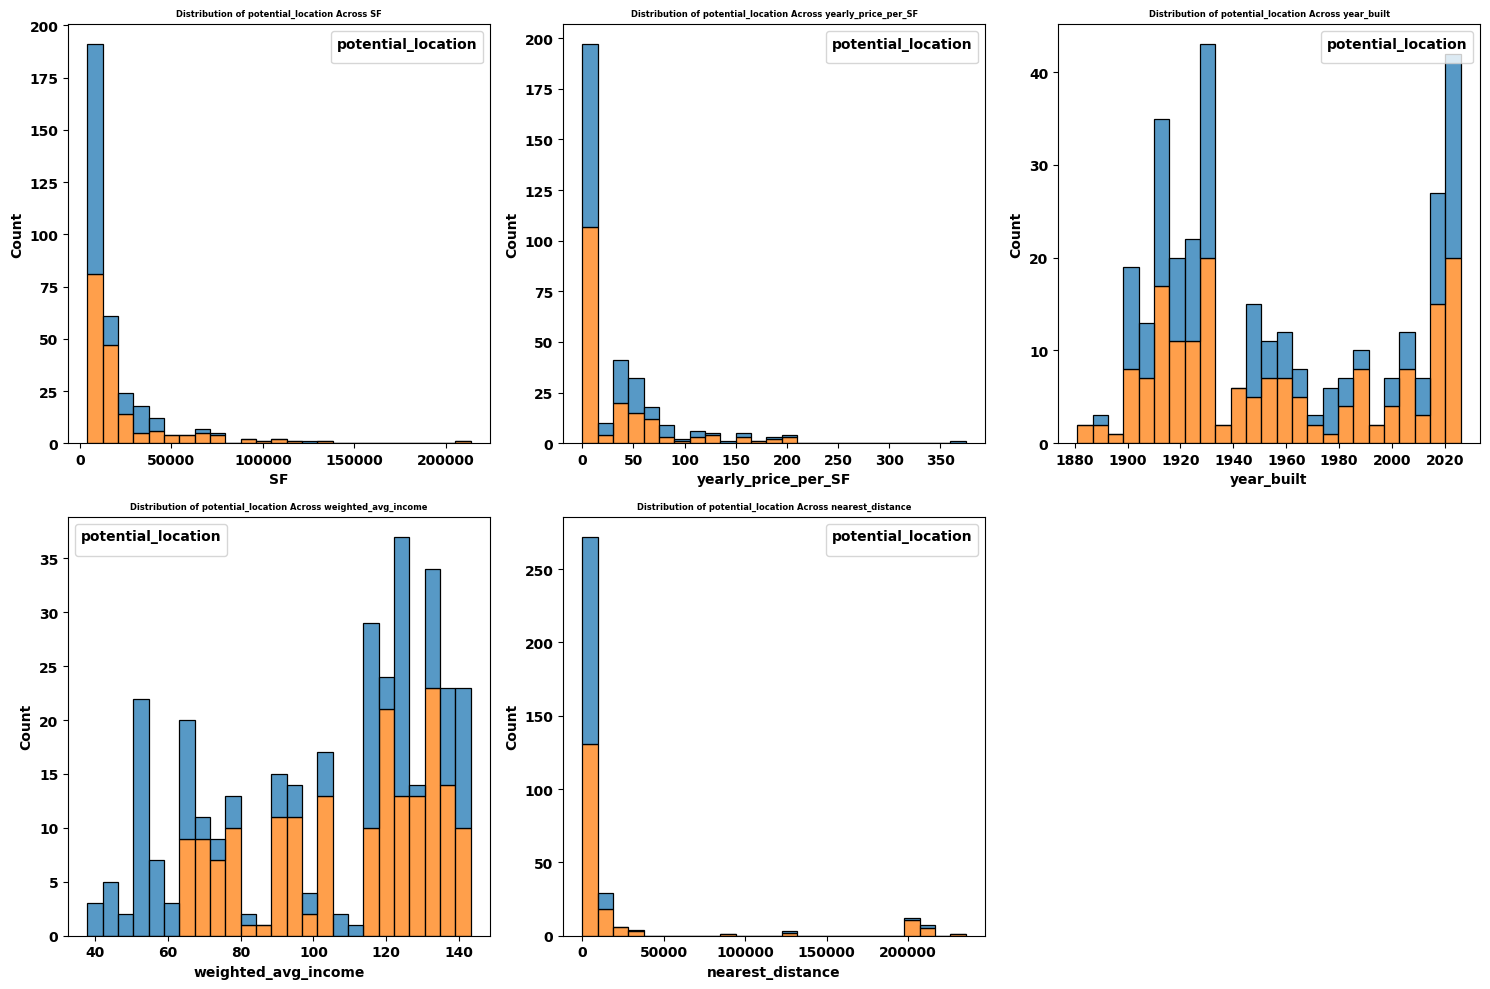

In [390]:
import numpy as np

# Determine the number of rows and columns for subplots
num_rows = (len(predictors) + 2) // 3  # Add 2 to account for the legend and title
num_cols = min(len(predictors), 3)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plotting each predictor individually
for i, predictor in enumerate(predictors):
    ax = axes[i]
    # Randomly sample the dataframe to balance the target variable classes
    df_sampled = pd.concat([
        df[df[target] == 0].sample(frac=0.5),
        df[df[target] == 1].sample(frac=1)
    ])
    sns.histplot(data=df_sampled, x=predictor, hue=target, multiple='stack', bins=25, ax=ax)
    ax.set_title(f'Distribution of {target} Across {predictor}', fontsize=6)  # Adjust the title fontsize
    ax.set_xlabel(predictor)
    ax.set_ylabel('Count')
    ax.legend(title=target)

# Remove empty subplots
for i in range(len(predictors), num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


The histogram analysis reveals an interesting trend in the distribution of categories across different frequencies. Specifically, as the frequency of occurrences increases, the distribution tends to favor category 0 slightly more. Conversely, when the frequency decreases, category 1 becomes more prevalent in the distribution.


In [393]:
selected_columns = predictors  # Replace with the column names you want to select
filtered_df = df[selected_columns]
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SF                   492 non-null    float64
 1   yearly_price_per_SF  492 non-null    float64
 2   year_built           492 non-null    int32  
 3   weighted_avg_income  492 non-null    float64
 4   nearest_distance     492 non-null    float64
dtypes: float64(4), int32(1)
memory usage: 17.4 KB


In [396]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Split data into features (X) and target (y)
X = filtered_df
y = df['potential_location']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
logreg = LogisticRegression()
rf = RandomForestClassifier()
svm = SVC()
gbm = GradientBoostingClassifier()
mlp = MLPClassifier()

# Train models
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)
svm.fit(X_train, y_train)
gbm.fit(X_train, y_train)
mlp.fit(X_train, y_train)

# Make predictions
logreg_preds = logreg.predict(X_test)
rf_preds = rf.predict(X_test)
svm_preds = svm.predict(X_test)
gbm_preds = gbm.predict(X_test)
mlp_preds = mlp.predict(X_test)

# Evaluate performance
models = [logreg, rf, svm, gbm, mlp]
model_names = ['Logistic Regression', 'Random Forest', 'SVM', 'Gradient Boosting', 'MLP']


print('TRAINING DATA')

for model, name in zip(models, model_names):
    preds = model.predict(X_train)
    accuracy = accuracy_score(y_train, preds)
    precision = precision_score(y_train, preds)
    recall = recall_score(y_train, preds)
    f1 = f1_score(y_train, preds)
    roc_auc = roc_auc_score(y_train, preds)
    
    print(f"Performance metrics for {name}:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")


print('TESTING DATA')

for model, name in zip(models, model_names):
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, preds)
    
    print(f"Performance metrics for {name}:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")


C:\Users\ydg88\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


TRAINING DATA
Performance metrics for Logistic Regression:
Accuracy: 0.6972, Precision: 0.6712, Recall: 0.3403, F1 Score: 0.4516, ROC AUC: 0.6219
Performance metrics for Random Forest:
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, ROC AUC: 1.0000
Performance metrics for SVM:
Accuracy: 0.7048, Precision: 0.7917, Recall: 0.2639, F1 Score: 0.3958, ROC AUC: 0.6119
Performance metrics for Gradient Boosting:
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, ROC AUC: 1.0000
Performance metrics for MLP:
Accuracy: 0.6870, Precision: 0.5415, Recall: 0.9514, F1 Score: 0.6902, ROC AUC: 0.7428
TESTING DATA
Performance metrics for Logistic Regression:
Accuracy: 0.6566, Precision: 0.5000, Recall: 0.2059, F1 Score: 0.2917, ROC AUC: 0.5491
Performance metrics for Random Forest:
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, ROC AUC: 1.0000
Performance metrics for SVM:
Accuracy: 0.6768, Precision: 0.6667, Recall: 0.1176, F1 Score: 0.2

In [ ]:
predictors

In [ ]:
323/169

In [ ]:
k=0
for i in (df_sampled.potential_location):
    if i ==0:
        k+=1
print(k)